In [37]:
import datasets
import pandas as pd
import json

In [2]:
dataset=datasets.DatasetDict.load_from_disk("/azurestorage/data/sentence_aligmnet_dataset_filtered")

# Preparing Dataset

In [18]:
train_ds=dataset["train"]
holdout_ds=dataset["test"]
train_df=train_ds.to_pandas().drop_duplicates("src_text")
train_df=train_df[train_df["src_text"].str.len()<6000]

<Axes: >

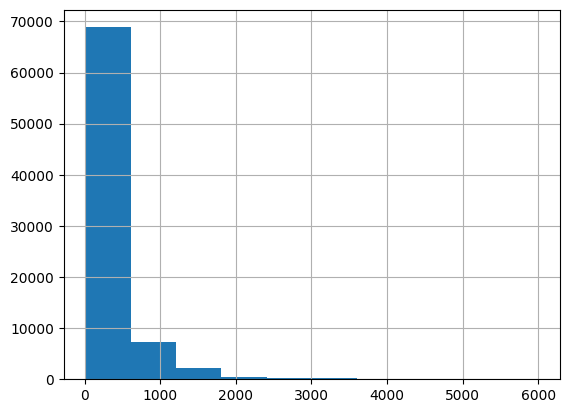

In [19]:
train_df["src_text"].str.len().hist()

In [20]:
train_df=train_df[train_df["src_text"].str.len()<6000]

In [21]:
new_train_df=pd.concat([train_df[train_df["src_text"].str.len()<1600].sample(frac=0.07),train_df[train_df["src_text"].str.len()>1600]]).sample(frac=1)

In [22]:
new_train_df

,src_text,tgt_text,context,selected_span,answer_span
222563,최근 해외 국채 금리가 바닥을 치고 오르면서 KEB하나은행이 판매한 DLF 투자액 ...,As interest rates on overseas government bonds...,As interest rates on overseas government bonds...,DLF investments,DLF 투자액
33250,이 오류는 `newgidmap` 및/또는 `newuidmap` 바이너리가 누락되었거...,The error you are encountering occurs when the...,"For Ubuntu or Debian-based systems, use the fo...",CentOS,CentOS
4569,"Yes, you can also make the `StateData` class a...","예, `StateData` 클래스를 추상화하고 하위 클래스에서 구체적인 구현을 만들...",그런 다음 `MyViewModel` 클래스에서 `MyStateData` 클래스를 사...,_stateData,_stateData
7960,"According to the World Gold Association, gold ...",세계 금 협회에 따르면 9월 금 ETF의 금 보유량은 전달보다 75톤 늘어나면서 총...,세계 금 협회에 따르면 9월 금 ETF의 금 보유량은 전달보다 75톤 늘어나면서 총...,9월,September
1811,Among the high-rank savings banks with high-in...,고금리대출 잔액 상위 저축은행 중에는 OK저축은행과 웰컴저축은행 고금리 비중이 70...,고금리대출 잔액 상위 저축은행 중에는 OK저축은행과 웰컴저축은행 고금리 비중이 70...,OK저축은행,OK Savings Bank
...,...,...,...,...,...
249542,The banking sector is struggling to adjust its...,은행권이 오는 12월 제2 안심전환대출용 주택저당증권(MBS) 발행을 앞두고 채권물...,은행권이 오는 12월 제2 안심전환대출용 주택저당증권(MBS) 발행을 앞두고 채권물...,발행,issuance
100316,Here's an example implementation of a Next.js ...,다음은 사용자의 취향에 따라 질문을 필터링하는 Next.js 서버리스 함수의 구현 ...,다음은 사용자의 취향에 따라 질문을 필터링하는 Next.js 서버리스 함수의 구현 ...,질문,questions
46721,다음은 시계열 데이터에 대해 LSTM을 훈련하는 방법을 보여주는 Python의 간단...,Here's an example of a simple script in Python...,Here's an example of a simple script in Python...,Evaluate the model on the test data,테스트 데이터에 대한 모델 평가
11345,The disciplinary plan is expected to be finali...,향후 10일간 은행 의견 수렴을 거쳐 내년 1월 16일이나 23일 열릴 제재심의위원...,향후 10일간 은행 의견 수렴을 거쳐 내년 1월 16일이나 23일 열릴 제재심의위원...,내년 1월 16일이나 23일,January 16 or 23 next year


In [67]:
new_train_df.to_csv("./sentence-alignment.csv")

<Axes: >

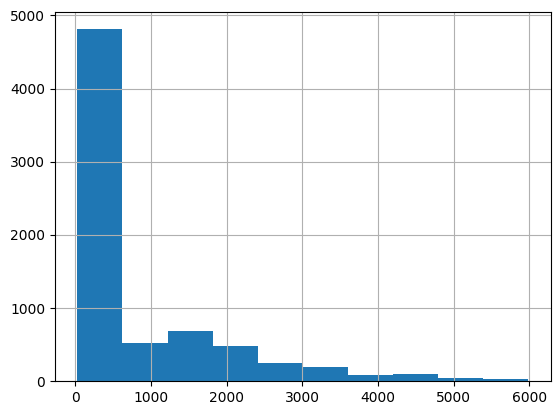

In [23]:
new_train_df["src_text"].str.len().hist()

# GPT API request

In [25]:
import os
import logging
import requests
import subprocess
import base64
import threading
import time

log = logging.getLogger(__name__)

class TokenManager:
    _instance = None
    _lock = threading.Lock()

    def __new__(cls, *args, **kwargs):
        with cls._lock:
            if cls._instance is None:
                cls._instance = super(TokenManager, cls).__new__(cls)
                cls._instance.initialized = False
        return cls._instance

    def __init__(self,
                id_broker_host,
                username,
                password,
                cert_path):
        # This check prevents the initialization code from running more than once.
        if self.initialized:
            return

        # Assume API_URL, USERNAME, and PASSWORD are environment variables
        self.id_broker_host = id_broker_host
        self._username = username
        self._password = password
        self.cert_path=cert_path
        self._gif_subs = os.getenv('DATAPLATFORM_API_KEY')
        self._external = True if self._gif_subs is not None else False

        # Validate the env variables required are set
        if self._username is None:
            raise ValueError("Environment variable 'USERNAME' is not set. 'USERNAME' must be set to user/service "
                             "account guid")
        if self._password is None:
            raise ValueError("Environment variable 'PASSWORD' is not set. 'PASSWORD' must be set to user/service "
                             "account password")
        if self.id_broker_host is None:
            raise ValueError("Environment variable 'ID_BROKER_HOST' is not set. 'ID_BROKER_HOST' must be dataplatform "
                             "id-broker host matching the GenAI environment.")

        self._token = None
        self._refresh = None
        self._expires_at = 0
        self.refresh_thread = threading.Thread(target=self._manage_token, daemon=True)
        self.refresh_thread.start()

        self.initialized = True  # Set the flag to True after initialization

    def _get_new_token_using_login(self):
        log.debug('Getting new token using username and password')

        credentials = f"{self._username}:{self._password}"
        encoded_credentials = base64.b64encode(credentials.encode('utf-8')).decode('utf-8')
        auth_header = f"Basic {encoded_credentials}"

        headers = {
            'Authorization': auth_header
        }

        if self._external:
            headers['Ocp-Apim-Subscription-Key'] = self._gif_subs

        response = requests.request("GET",
                                    f"{self.id_broker_host}/api/v1/public/login",
                                    headers=headers,
                                    verify=self.cert_path)

        if response.status_code == 204:
            self._token = response.headers['Authorization']
            self._refresh = response.headers['Refresh-Token']
            self._expires_at = time.time() + 3600
        else:
            raise ValueError(f'Failed to get token for user: {self._username} Code: {response.status_code}')

    def _get_new_token_using_refresh(self):
        log.debug('Getting new token using refresh token')

        headers = {
            'refreshToken': self._refresh
        }

        response = requests.request("GET",
                                    f"{self.id_broker_host}/api/v1/public/refresh",
                                    headers=headers,
                                    verify=self.cert_path)

        if response.status_code == 204:
            self._token = response.headers['Authorization']
            self._refresh = response.headers['Refresh-Token']
            self._expires_at = time.time() + 3600
        else:
            raise ValueError(f'Failed to get token for user: {self._username} Code: {response.status_code}')

    def get_token(self):
        with self._lock:
            # Return the current valid token
            return self._token

    def _manage_token(self):
        while True:
            try:
                # If no token, get a new one. Else, wait until it's time to refresh.
                if not self._token or time.time() >= self._expires_at - 300:
                    self._renew_token()
                else:
                    time_to_sleep = max(self._expires_at - time.time() - 300, 0)
                    time.sleep(time_to_sleep)
            except ValueError as e:
                log.exception(f'Token refresh failed due to {e}')
                time.sleep(10)

    def _renew_token(self):
        with self._lock:
            if self._refresh and time.time() < self._expires_at and not self._external:
                self._get_new_token_using_refresh()
            else:
                self._get_new_token_using_login()

    def invalidate_token(self):
        with self._lock:
            self._token = None
            self._refresh = None
            self._expires_at = 0

In [ ]:
"/workspace/apps/taxionary/llm_engine/cacert.pem"

In [53]:
id_broker_host='https://dp-idbroker-au.pwclabs.pwcglb.com'
model_name='gpt-4-32k'
api_version="2023-06-01-preview"
api_key="8062f07fa662496294dc68e1efb9d2a5"
cert_path="/workspace/apps/taxionary/llm_engine/cacert.pem"
token_manager=TokenManager(id_broker_host=id_broker_host,
                         username='jleez922',
                         password='dlfjsghksA1~',
                         cert_path=cert_path,)

url=f"https://gif-apim.pwc.com/ngc/prod-au/openai/v2/openai/deployments/{model_name}/chat/completions?api-version={api_version}&subscription-key={api_key}"

In [62]:
def interact_with_chatpwc_api(data:dict): 
    headers = {  
            'accept': 'application/json',  
        'x-request-type': 'sync',  
        'x-pool-type': 'shared',  
        'Authorization': token_manager.get_token(),  
        'Ocp-Apim-Subscription-Key': api_key,
        'Content-Type': 'application/json',
    }  

    response=requests.request("POST",
                    url,
                    headers=headers,
                    json=data)


    response=json.loads(response.text)
    print(response)
    response=response["choices"][0]["message"]["content"]
    return response

In [63]:
src_text='''오픈AI는 이날부터 가입 절차 없이 챗GPT를 바로 사용할 수 있도록 할 것이고 단계적으로 서비스를 확대할 계획이라고 설명했다.

계정 없이 챗GPT를 사용할 때는 AI를 통해 질문에 대한 답변을 얻는 기본적인 서비스는 똑같이 이용할 수 있다. 다만 로그인을 하지 않은 이용자가 챗GPT를 남용할 가능성에 대비해 오픈AI는 상당한 범위의 질문과 답변을 봉쇄할 것이라고 밝혔다.

로그인을 하면 추가로 이용할 수 있는 기능도 있다. 로그인을 할 경우 챗GPT에 남긴 채팅 기록을 저장하고, 검토·공유할 수 있다. 음성 대화 기능을 이용하거나 맞춤형 지시 등도 가능하다.

이번 조치는 챗GPT 외에 다른 오픈AI가 개발한 도구는 해당하지 않는다. 이미지를 생성하는 AI ‘달리’(DALL-E) 등 다른 서비스를 이용할 때는 필수적으로 로그인해야 한다.

챗GPT는 2022년 출시돼 2개월 만에 사용자 1억명을 돌파했고 사람이 작성한 것과 비슷한 수준의 글을 몇 초 만에 내놓는 등 획기적 성능을 선보였다. 학생들 사이에서 큰 인기를 끌면서 학교에서는 표절을 방지하는 방안을 찾아야 할 정도로 급속히 퍼져나갔고 직장인들도 코드 작성 및 연구 수행 등 목적으로 폭넓게 사용했다.

챗GPT는 지난해 5월 이용자수 18억명을 돌파한 이후에는 성장세가 둔화하고 있다. 지난달에는 테슬라 최고경영자(CEO)인 일론 머스크가 인류의 공동 이익을 위해 인공지능을 개발하겠다던 오픈AI가 회사 설립 당시 계약을 위반했다며 오픈AI와 샘 올트먼 CEO를 상대로 소송을 제기하기도 했다.'''


tgt_text='''OpenAI said that starting from today, users will be able to use ChatGPT without going through the subscription process and will gradually expand the service. When using ChatGPT without an account, users can still use the basic service of getting answers to questions through AI. However, OpenAI said that it will block a considerable range of questions and answers to prevent abuse by unlogged users.

If you log in, there are additional features available. If you log in, you can save your chat history on ChatGPT, review and share it. You can also use voice conversation functions or customized instructions.

This measure does not apply to other OpenAI-developed tools other than ChatGPT. You must log in to use other services such as DALL-E, which creates images. ChatGPT was launched in 2022 and surpassed 100 million users in two months, and it has shown groundbreaking performance by producing texts similar to those written by humans in seconds. It spread rapidly, requiring schools to find ways to prevent plagiarism, and office workers used it widely for purposes such as code writing and research.

ChatGPT's growth has slowed down since it surpassed 1.8 billion users in May last year. In December, Tesla CEO Elon Musk filed a lawsuit against OpenAI and CEO Sam Altman, claiming that OpenAI violated the contract when the company was founded, saying that they would develop artificial intelligence for the common good of humanity.'''

In [64]:
prompt=f'''Given two pieces of text where one is in English and the other is in Korean, your task is to carefully read both texts and identify corresponding sentences or statements between the English text and the Korean text.
This includes situations where a single sentence corresponds to multiple sentences, due to linguistic differences and the need for additional clarification in translation.  
Each identified pair should consist of one source sentence and its translation, indicating that they convey the same information.

Here goes some examples.

example1)
source_text = "In order to prevent international tax avoidance, the Base Erosion and Profit Shifting project proposed a plan to expand the scope of permanent establishment in the treaty through concluding short-term contracts and reducing the period to reduce taxation of the source country. On the other hand, the UK and Australia amended the tax laws to introduce the Diverted Profits Tax, which applies a higher rate than the usual rate of corporate tax on profits that multinational companies transfer abroad. In this meeting, we discuss the change of the concept of permanent establishment related to the above Base Erosion and Profit Shifting project, reviews each case on the Diverted Profits Tax of the UK and Australia, and discusses the proper position of South Korea in each case."
target_text = "국제 조세 회피 방지를 위해 세원잠식 및 소득이전(BEPS) 프로젝트는 단기 계약을 체결하여 조약상의 고정사업장의 범위를 확대하고 조세 부담국의 조세를 감축하기 위한 기간을 줄이는 방안을 제시하였다. 한편 영국과 호주는 다국적 기업이 해외로 양도하는 이익에 대하여 법인세의 보통 요율보다 높은 요율을 적용하는 우회이익세를 도입하기 위하여 조세법을 개정하였다. 본 회의에서는 위와 같은 세원잠식 및 소득이전(BEPS) 프로젝트와 관련된 고정사업장에 대한 개념의 변화, 영국과 호주의 우회이익세에 관한 각 사례 검토, 그리고 각 사례별 우리나라의 적정한 입장에 대해 논의한다."
extracted_pairs=[("In order to prevent international tax avoidance, the Base Erosion and Profit Shifting project proposed a plan to expand the scope of permanent establishment in the treaty through concluding short-term contracts and reducing the period to reduce taxation of the source country.","국제 조세 회피 방지를 위해 세원잠식 및 소득이전(BEPS) 프로젝트는 단기 계약을 체결하여 조약상의 고정사업장의 범위를 확대하고 조세 부담국의 조세를 감축하기 위한 기간을 줄이는 방안을 제시하였다. "),("On the other hand, the UK and Australia amended the tax laws to introduce the Diverted Profits Tax, which applies a higher rate than the usual rate of corporate tax on profits that multinational companies transfer abroad.","한편 영국과 호주는 다국적 기업이 해외로 양도하는 이익에 대하여 법인세의 보통 요율보다 높은 요율을 적용하는 우회이익세를 도입하기 위하여 조세법을 개정하였다."),("In this meeting, we discuss the change of the concept of permanent establishment related to the above Base Erosion and Profit Shifting project, reviews each case on the Diverted Profits Tax of the UK and Australia, and discusses the proper position of South Korea in each case.","본 회의에서는 위와 같은 세원잠식 및 소득이전(BEPS) 프로젝트와 관련된 고정사업장에 대한 개념의 변화, 영국과 호주의 우회이익세에 관한 각 사례 검토, 그리고 각 사례별 우리나라의 적정한 입장에 대해 논의한다.")]

example2)
source_text = "계약상 현금흐름의 수취와 금융자산 둘 다를 통해 목적을 이루는 사업모형 하에서 금융자산을 보유하고, 계약상 현금흐름이 원리금만으로 구성되어 있는 금융자산은 기타포괄손익-공정가치로 측정합니다. 손상차손(환입)과 이자수익 및 외환손익을 제외하고는, 기타포괄손익-공정가치로 측정하는 금융자산의 손익은 기타포괄손익으로 인식합니다. 금융자산을 제거할 때에는 인식한 기타포괄손익누계액을 자본에서 당기손익으로 재분류합니다. 유효이자율법에 따라 인식하는 금융자산의 이자수익은 '금융수익'에 포함됩니다. 외환손익은 '기타영업외수익 또는 기타영업외비용'으로표시하고 손상차손은 '기타영업외비용'으로 표시합니다."
target_text = "A financial asset is measured at FVTPL if it is held in a business model where the objective is achieved through both the receipt of contractual cash flows and the financial asset, and the contractual cash flows consist solely of principal. Gains and losses on financial assets at fair value through other comprehensive income are recognized in other comprehensive income, except for impairment losses (reversals), interest income and foreign exchange gains and losses. When a financial asset is derecognized, the amount of accumulated other comprehensive income (loss) recognized in other comprehensive income (loss) is reclassified from equity to profit or loss. Interest income on financial assets recognized using the effective interest rate method is included in 'Finance income'. Foreign exchange gains and losses are presented in 'Other non-operating income or expense' and impairment losses are presented in 'Other non-operating expenses'."
extracted_pairs=[("계약상 현금흐름의 수취와 금융자산 둘 다를 통해 목적을 이루는 사업모형 하에서 금융자산을 보유하고, 계약상 현금흐름이 원리금만으로 구성되어 있는 금융자산은 기타포괄손익-공정가치로 측정합니다.","A financial asset is measured at FVTPL if it is held in a business model where the objective is achieved through both the receipt of contractual cash flows and the financial asset, and the contractual cash flows consist solely of principal."),("손상차손(환입)과 이자수익 및 외환손익을 제외하고는, 기타포괄손익-공정가치로 측정하는 금융자산의 손익은 기타포괄손익으로 인식합니다.","Gains and losses on financial assets at fair value through other comprehensive income are recognized in other comprehensive income, except for impairment losses (reversals), interest income and foreign exchange gains and losses."),("금융자산을 제거할 때에는 인식한 기타포괄손익누계액을 자본에서 당기손익으로 재분류합니다.","When a financial asset is derecognized, the amount of accumulated other comprehensive income (loss) recognized in other comprehensive income (loss) is reclassified from equity to profit or loss."),("유효이자율법에 따라 인식하는 금융자산의 이자수익은 '금융수익'에 포함됩니다.","Interest income on financial assets recognized using the effective interest rate method is included in 'Finance income'. "),("외환손익은 '기타영업외수익 또는 기타영업외비용'으로표시하고 손상차손은 '기타영업외비용'으로 표시합니다.","Foreign exchange gains and losses are presented in 'Other non-operating income or expense' and impairment losses are presented in 'Other non-operating expenses'.")]

source_text = {src_text}
target_text = {tgt_text}
extracted_pairs ='''

In [65]:
print(prompt)

Given two pieces of text where one is in English and the other is in Korean, your task is to carefully read both texts and identify corresponding sentences or statements between the English text and the Korean text.
This includes situations where a single sentence corresponds to multiple sentences, due to linguistic differences and the need for additional clarification in translation.  
Each identified pair should consist of one source sentence and its translation, indicating that they convey the same information.

Here goes some examples.

example1)
source_text = "In order to prevent international tax avoidance, the Base Erosion and Profit Shifting project proposed a plan to expand the scope of permanent establishment in the treaty through concluding short-term contracts and reducing the period to reduce taxation of the source country. On the other hand, the UK and Australia amended the tax laws to introduce the Diverted Profits Tax, which applies a higher rate than the usual rate of 

In [66]:


data = {  
        "messages": [  
            {  
                "role": "user",  
                "content":prompt
            }  
        ],  
        "max_tokens": 16000
        # "stream": True  
    }  
        
        # 클라이언트에게 응답 데이터 전송
response=interact_with_chatpwc_api(data=data)




{'error': {'message': "'$.messages[0].content' is invalid. Please check the API reference: https://platform.openai.com/docs/api-reference.", 'type': 'invalid_request_error', 'param': None, 'code': None}}


KeyError: 'choices'

In [60]:
response

'[("오픈AI는 이날부터 가입 절차 없이 챗GPT를 바로 사용할 수 있도록 할 것이고 단계적으로 서비스를 확대할 계획이라고 설명했다.","OpenAI said that starting from today, users will be able to use ChatGPT without going through the subscription process and will gradually expand the service."),("계정 없이 챗GPT를 사용할 때는 AI를 통해 질문에 대한 답변을 얻는 기본적인 서비스는 똑같이 이용할 수 있다. 다만 로그인을 하지 않은 이용자가 챗GPT를 남용할 가능성에 대비해 오픈AI는 상당한 범위의 질문과 답변을 봉쇄할 것이라고 밝혔다.","When using ChatGPT without an account, users can still use the basic service of getting answers to questions through AI. However, OpenAI said that it will block a considerable range of questions and answers to prevent abuse by unlogged users."),("로그인을 하면 추가로 이용할 수 있는 기능도 있다. 로그인을 할 경우 챗GPT에 남긴 채팅 기록을 저장하고, 검토·공유할 수 있다. 음성 대화 기능을 이용하거나 맞춤형 지시 등도 가능하다.","If you log in, there are additional features available. If you log in, you can save your chat history on ChatGPT, review and share it. You can also use voice conversation functions or customized instructions."),("챗GPT는 2022년 출시돼 2개월 만에 사용자 1억명을 돌파했고 사람이 작성한 것과 비슷한 